In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

# Load data

In [2]:
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors():
    ratings = load_pickle('data/interaction_ratings')
    book_vectors = load_pickle('data/interaction_dict_book_factor')
    user_vectors = load_pickle('data/interaction_dict_reader_factor')
    return ratings, book_vectors, user_vectors

interactions_dict, book_vectors, user_vectors = load_ratings_and_factors()

Compute the 1000 x 200 user-book interaction matrix 'interactions', where interactions[i][j] == 1 if and only if user i has interacted with book j.

In [3]:
max_i = max(key[0] for key in interactions_dict.keys())
max_j = max(key[1] for key in interactions_dict.keys())
num_rows = max_i
num_cols = max_j

print(num_rows, 'users')
print(num_cols, 'books')

result_array = np.zeros((num_rows, num_cols), dtype=int)

for (i, j), value in interactions_dict.items():
    result_array[i-1, j-1] = value

# the 1000 x 200 matrix of user-book interactions
interactions = result_array

1000 users
200 books


Compute the normalized embeddings of each book. book_vectors_normalized[j] is the 10-dimensional normalized embedding for book j.

In [4]:
def normalize(v, phi=1):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / (norm ** phi)

book_vectors_normalized = np.array([normalize(v) for v in book_vectors])

Compute a list of book interactions for each user. interactions_list[i] is a list of books that user i has interacted with.

In [5]:
interactions_list = [[] for _ in range(1000)]
for i in range(1000):
    if np.sum(interactions[i]) > 1:
        interactions_list[i] = list(np.squeeze(np.where(interactions[i]==1)))

Define a function to return a train and test set for a given user.

In [6]:
''' return a train set of book indices, and a single test book index'''
def get_train_test(user, size):
    assert np.sum(interactions[user]) > size
    train_moods = list(random.sample(interactions_list[user], size + 1))
    test_mood = train_moods.pop(random.randint(0, size))
    return train_moods, test_mood

train_moods, test_mood = get_train_test(1, 10)
print(train_moods, test_mood)

[87, 86, 68, 89, 84, 93, 50, 57, 56, 78] 80


Compute the 200x200 matrix giving, where the i,j entry is the dot product between book i and book j.

In [7]:
book_vector_dots = book_vectors_normalized @ book_vectors_normalized.T

Define a function to evaluate a set of recommendations given a user's mood. Returns both accuracy (average value of recommendations), and utility (maximum value of recommendations)

In [8]:
def relu(x):
    return max(0, x)

def evaluate(recommendations, test_mood, book_vector_dots):
    acc = 0
    for j in recommendations:
            acc += relu(book_vector_dots[test_mood][j])
    acc = acc / len(recommendations)

    utility = 0

    max_value = 0
    for j in recommendations:
        value = relu(book_vector_dots[test_mood][j])
        if value > max_value:
            max_value = value
    utility += max_value

    return acc, utility

Define a function to return a set of empirically accuracy-maximizing recommendations given a user's past interactions.

In [9]:
def get_recommendations(train_moods, book_vector_dots, size):
    pred_values = []
    for i in range(200):
        pred_values.append(np.sum([relu(book_vector_dots[i][j]) for j in train_moods]))
    
    recommendations = []
    sorted_list = list(reversed(list(np.argsort(pred_values))))
    while len(recommendations) < size:
        i = sorted_list.pop(0)
        if i not in train_moods:
            recommendations.append(i)

    return recommendations

# Given past interactions [78, 90, 101, 88, 63], return a set of 5 accurate recommendations.
print('Accurate recommendations:', get_recommendations([78, 90, 101, 88, 63], book_vector_dots, 5))

Accurate recommendations: [29, 138, 47, 57, 37]


Define a function to return a random set of size 'size' from a set of candidate books.

In [10]:
def get_recommendations_random(test_candidates, size):
    return random.sample(test_candidates, size)

Define a function to return a heuristically diverse set of books that match a user's past distribution of interactions.

In [11]:
def get_recommendations_diverse(train_moods, book_vector_dots, size):
    recommendations = []
    
    index = 0
    while len(recommendations) < size:
        index += 1
        j = train_moods[index % len(train_moods)]
        pred_values = []
        for i in range(200):
            pred_values.append(relu(book_vector_dots[i][j]))
        
        sorted_list = list(reversed(list(np.argsort(pred_values))))
        while len(recommendations) < size:
            i = sorted_list.pop(0)
            if i not in train_moods and i not in recommendations:
                recommendations.append(i)
                break

    return recommendations

# Given past interactions [78, 90, 101, 88, 63], return a set of 5 diverse recommendations.
print('Diverse recommendations:', get_recommendations_diverse([78, 90, 101, 88, 63], book_vector_dots, 5))

Diverse recommendations: [87, 123, 29, 138, 80]


Return a measure of diversity of a set of recommendations, equal to the average cosine distance between recommendations in the set.

In [12]:
def diversity(recommendations, book_vector_dots):
    score = 0
    num_recs = len(recommendations)
    # print(recommendations)
    # print(np.shape(book_vector_dots))
    for i in range(num_recs):
        for j in range(i, num_recs):
            score += 1 - book_vector_dots[recommendations[i]][recommendations[j]]
    return score / (num_recs * (num_recs - 1) / 2)

# Run Experiment

Compare accuracy-maximizing recommendations to heurstically-chosen diverse recommendations, varying the number of recommendations made.

In [13]:
book_vector_dots = book_vectors_normalized @ book_vectors_normalized.T

users = [i for i in range(1000) if np.sum(interactions[i]) >= 20]

acc_means = []
utility_means = []
acc_means_diverse = []
utility_means_diverse = []
acc_vars = []
utility_vars = []
acc_vars_diverse = []
utility_vars_diverse=[]
div_means = []
div_means_diverse = []

for n in [10, 20, 30, 40, 50]:
    acc_list = [[] for _ in users]
    utility_list = [[] for _ in users]
    acc_list_diverse = [[] for _ in users]
    utility_list_diverse = [[] for _ in users]
    div_list = [[] for _ in users]
    div_list_diverse = [[] for _ in users]

    for _ in range(100):
        for index, i in enumerate(users):
            if np.sum(interactions[i]) >= 20:
                train_moods, test_mood = get_train_test(0, 10)
                recs = get_recommendations(train_moods, book_vector_dots, n)
                recs_diverse = get_recommendations_diverse(train_moods, book_vector_dots, n)

                div_list[index].append(diversity(recs, book_vector_dots))
                div_list_diverse[index].append(diversity(recs_diverse, book_vector_dots))

                acc, utility = evaluate(recs, test_mood, book_vector_dots)
                acc_list[index].append(acc)
                utility_list[index].append(utility)
                acc, utility = evaluate(recs_diverse, test_mood, book_vector_dots)
                acc_list_diverse[index].append(acc)
                utility_list_diverse[index].append(utility)

    acc_means.append(np.mean(acc_list))
    acc_vars.append(np.mean(np.var(acc_list, axis=1)))
    utility_means.append(np.mean(utility_list))
    utility_vars.append(np.mean(np.var(utility_list, axis=1)))
    div_means.append(np.mean(div_list))
    
    acc_means_diverse.append(np.mean(acc_list_diverse))
    acc_vars_diverse.append(np.mean(np.var(acc_list_diverse, axis=1)))
    utility_means_diverse.append(np.mean(utility_list_diverse))
    utility_vars_diverse.append(np.mean(np.var(utility_list_diverse, axis=1)))
    div_means_diverse.append(np.mean(div_list_diverse))

# Figure 4

Make plot.

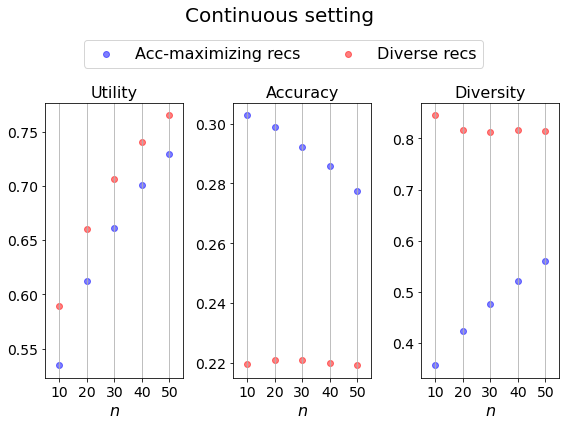

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,6))

ns = [10, 20, 30, 40, 50]

for ax in [ax1, ax2, ax3]:
    ax.grid(axis='x')
    ax.set_xticks(ns)
    ax.tick_params(labelsize=14)
    ax.set_xlim(5,55)
    ax.set_xlabel(r'$n$', fontsize=16)

ax2.scatter(ns, acc_means, color='blue', alpha = 0.5, label='Acc-maximizing recs')
ax2.scatter(ns, acc_means_diverse, color='red', alpha = 0.5, label='Diverse recs')
ax2.set_title('Accuracy', fontsize=16)

ax1.scatter(ns, utility_means, color='blue', alpha = 0.5)
ax1.scatter(ns, utility_means_diverse, color='red', alpha = 0.5)
ax1.set_title('Utility', fontsize=16)

ax3.scatter(ns, div_means, color='blue', alpha = 0.5)
ax3.scatter(ns, div_means_diverse, color='red', alpha = 0.5)
ax3.set_title('Diversity', fontsize=16)

fig.legend(fontsize=16, loc="lower center", ncol = 2, bbox_to_anchor=(0.5, 0.82))

fig.suptitle('Continuous setting \n\n', fontsize=20)
fig.tight_layout(pad=1.2)
plt.savefig('goodreads.png', dpi=300)
plt.show()